In [1]:
import time
from cmath import exp, pi

import numpy as np
import matplotlib.pyplot as plt


## Parameters

In [2]:
# num harmonics
n = 14
# max frequency
w_max = 1800
# num model steps
N = 256
# N = 512

random_seed = 100

In [3]:
def generate_signal(n, w_max, N, max_A=1.0, print_info=True):
    """
    Generate random signal.
    
    :param int n: number of harmonics.
    :param float w_max: maximum frequency.
    :param int N: number of generation steps.
    :param float max_A: max amplitude of individual harmonics.
    :param boolean print_info: whether to print frequences,
                               amplitudes and phases of harmonics.
    :return np.ndarray result_signal: shape = (N, )
    
    """    
    w_step = w_max / n
    w = np.array([i * w_step for i in range(1, n + 1)])
    w.resize((n, 1))
    
    # generate amplitudes and phases
    amplitudes = np.random.random((n, 1)) * max_A
    phases = np.random.randint(-15, 15, size=(n, 1))
    harmonics = [np.linspace(0, N, num=N) for i in range(n)]
    harmonics = np.array(harmonics)
    
    harmonics = amplitudes * np.sin(w * harmonics + phases)
    result_signal = harmonics.sum(axis=0, keepdims=False)
    
    if print_info:
        print("Frequencies: \n", w)
        print("Amplitudes :\n", amplitudes)
        print("Phases :\n", phases)

        
    return result_signal
    

## Calculations 

In [4]:
# np.random.seed(random_seed)
signal_x = generate_signal(n, w_max, N, print_info=False)

mean = signal_x.mean()
print(mean)

dispersion = signal_x.std() ** 2
print(dispersion)


0.024351731401404043
2.774433892842457


## Graphs

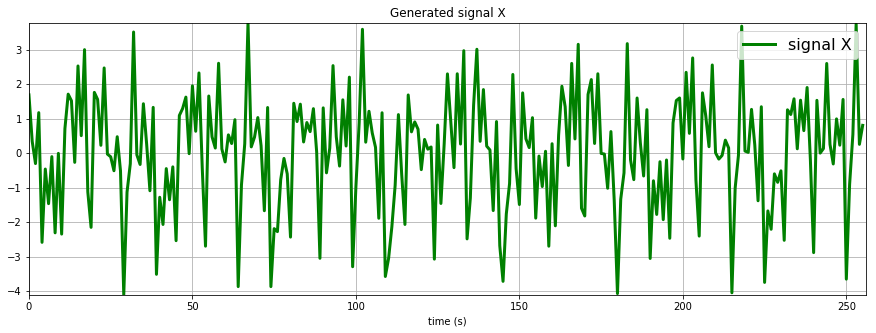

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

ax.plot(signal_x, color="green", linewidth=3, ls="-")
ax.set(title="Generated signal X", xlabel="time (s)")
ax.legend(["signal X"], fontsize=16, loc=0)
ax.grid()
ax.set(xlim=[0, N], ylim=[signal_x.min(), signal_x.max()])

plt.show()

### Discrete Fourier Transformer

In [6]:
class DFT:
    def __init__(self, N):
        """
        :param int N: Number of discrete points
        """ 
        self.N = N
        self.table = self.create_table(N)
    
    def create_table(self, N):
        W = np.zeros((N, N, 2))
        for p in range(N):
            for k in range(N):
                re = np.cos(2 * np.pi * p * k / N)
                im = np.sin(2 * np.pi * p * k / N)
                W[p, k] = (re, im) 
        return W
    
    def transform(self, signal_x, mode="fast_vectorized"):
        """
        :param np.ndarray signal_x: 1D array 
        :param str mode: type of algorithm, possible values "fast", "standard", "table", "fast_vectorized"
        """
        if mode.lower() == "fast_vectorized":
            if np.log2(len(signal_x)) % 1 > 0:
                raise ValueError("size of signal_x must be a power of 2")
            dft_x = np.abs(self.fft_vectorized(signal_x))
            
        elif mode.lower() == "fast":
            if np.log2(len(signal_x)) % 1 > 0:
                raise ValueError("size of signal_x must be a power of 2")
            dft_x = np.abs(self.fft(signal_x))
            
        elif mode.lower() == "table":
            dft_x = self.dft_table(signal_x)
            
        elif mode.lower() == "standard":
            dft_x = self.dft_standard(signal_x)
            
        else:
            print("Error! Unknown mode options", mode.lower())
            print('Possible mode values: "fast", "standard", "table", "fast_vectorized".')
            return None
        return dft_x
        
    def dft_standard(self, signal_x): 
        F = np.zeros((self.N, 2))
        for p in range(self.N):
            re, im = 0, 0
            for k in range(self.N):
                re += signal_x[k] * np.cos(2 * np.pi * p * k / self.N)
                im += signal_x[k] * np.sin(2 * np.pi * p * k / self.N)
            F[p, :] = (re, im)
            
        dft_x = np.sqrt(F[:, 0] ** 2 + F[:, 1] ** 2)
        return dft_x
        
    def dft_table(self, signal):
        F = np.zeros((N, 2))
        
        for p in range(N):
            re, im = 0, 0
            for k in range(N):
                re += signal[k] * self.table[p, k, 0]
                im += signal[k] * self.table[p, k, 1]
            F[p, :] = (re, im)
            
        dft_x = np.sqrt(F[:, 0] ** 2 + F[:, 1] ** 2)
        return dft_x
    
    def fft(self, signal):
        N = len(signal)
        if N <= 1: return signal
            
        even = self.fft(signal[0:: 2])
        odd =  self.fft(signal[1:: 2])
        
        T = [exp(-2j * pi * k / N) * odd[k] for k in range(N // 2)]
        return [even[k] + T[k] for k in range(N // 2)] + \
               [even[k] - T[k] for k in range(N // 2)]
   
    def fft_vectorized(self, signal):
        N = signal.shape[0]
        if N <= 1: return signal
        
        even = self.fft(signal[0:: 2])
        odd =  self.fft(signal[1:: 2])
        
        k = np.arange(0, N // 2)
        T = np.exp(-2j * np.pi * k / N) * odd
        return np.concatenate((even + T, even - T))
        

In [7]:
transformer = DFT(N)

%timeit transformer.transform(signal_x, mode="standard")
%timeit transformer.transform(signal_x, mode="table")
%timeit transformer.transform(signal_x, mode="fast")
%timeit transformer.transform(signal_x, mode="fast_vectorized")


175 ms ± 7.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
77.7 ms ± 8.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.83 ms ± 470 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.3 ms ± 257 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
transformer = DFT(N)

dft_x = transformer.transform(signal_x, mode="standard")
dft_x2 = transformer.transform(signal_x, mode="table")
dft_x3 = transformer.transform(signal_x, mode="fast")
dft_x4 = transformer.transform(signal_x, mode="fast_vectorized")


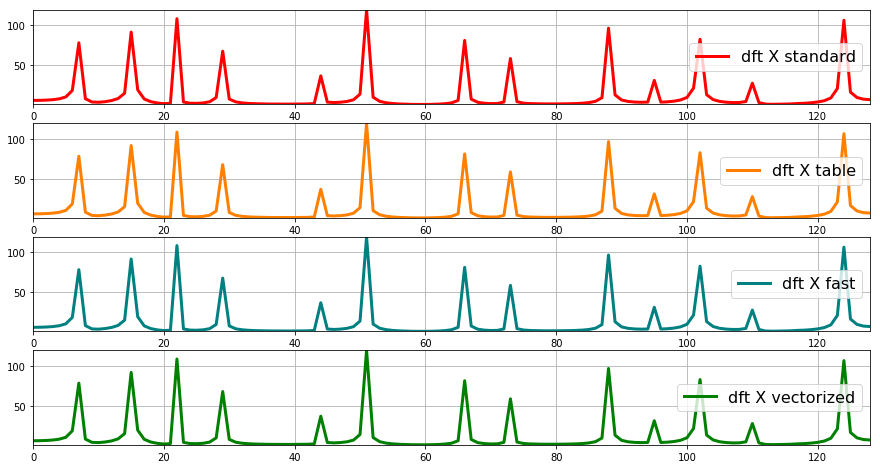

In [9]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 8))

ax[0].plot(dft_x , color=(1, 0, 0), linewidth=3, ls="-")
# ax[0].set(title="Discrete Fourier Trunsform of signal X", xlabel="")
ax[0].legend(["dft X standard"], fontsize=16, loc=0)
ax[0].grid()
ax[0].set(xlim=[0, N/2], ylim=[dft_x .min(), dft_x.max()])

ax[1].plot(dft_x2 , color=(1, 0.5, 0), linewidth=3, ls="-")
# ax[1].set(title="Discrete Fourier Trunsform of signal X by using tables", xlabel="")
ax[1].legend(["dft X table"], fontsize=16, loc=0)
ax[1].grid()
ax[1].set(xlim=[0, N/2], ylim=[dft_x2.min(), dft_x2.max()])

ax[2].plot(dft_x3 , color=(0, 0.5, 0.5), linewidth=3, ls="-")
# ax[2].set(title="Discrete Fourier Trunsform of signal X", xlabel="")
ax[2].legend(["dft X fast"], fontsize=16, loc=0)
ax[2].grid()
ax[2].set(xlim=[0, N/2], ylim=[dft_x3.min(), dft_x3.max()])

ax[3].plot(dft_x4 , color=(0, 0.5, 0), linewidth=3, ls="-")
# ax[3].set(title="Discrete Fourier Trunsform of signal X by using tables", xlabel="")
ax[3].legend(["dft X vectorized"], fontsize=16, loc=0)
ax[3].grid()
ax[3].set(xlim=[0, N/2], ylim=[dft_x4.min(), dft_x4.max()])

plt.show()

### Comparison dft algorithms speed 

In [10]:
transformer = DFT(N)

In [48]:
%%time

times_dft = []
times_fft = []
N_list = [128, 256, 512, 1024, 2048, 4096]

for i in N_list:
    transformer = DFT(i)
    x = generate_signal(n, w_max, i, print_info=False)
    start_time = time.time()
    dft_x = transformer.transform(x, mode="standard")
    end_time = time.time()
    times_dft.append(end_time - start_time)
    
    start_time = time.time()
    fft_x = transformer.transform(x, mode="fast")
    end_time = time.time()
    times_fft.append(end_time - start_time)
    


Wall time: 2min 21s


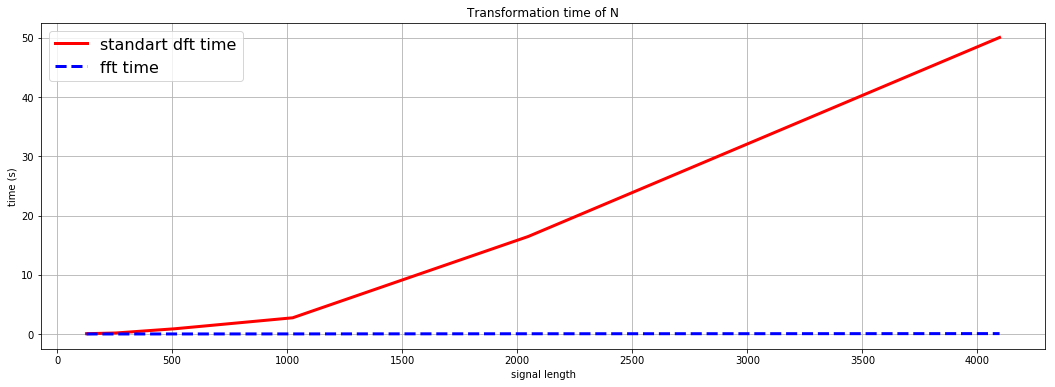

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

ax.plot(N_list, times_dft, color=(1, 0, 0), linewidth=3, ls="-", label="standart dft time")
ax.plot(N_list, times_fft, color=(0, 0, 1), linewidth=3, ls="--", label="fft time")
ax.set(title="Transformation time of N", xlabel="signal length", ylabel="time (s)")
ax.legend(fontsize=16, loc=0)
ax.grid()
#ax.set(xlim=[0, N], ylim=[signal_x.min(), signal_x.max()])

plt.show()

In [50]:
acceleration = np.array(times_dft) / np.array(times_fft)

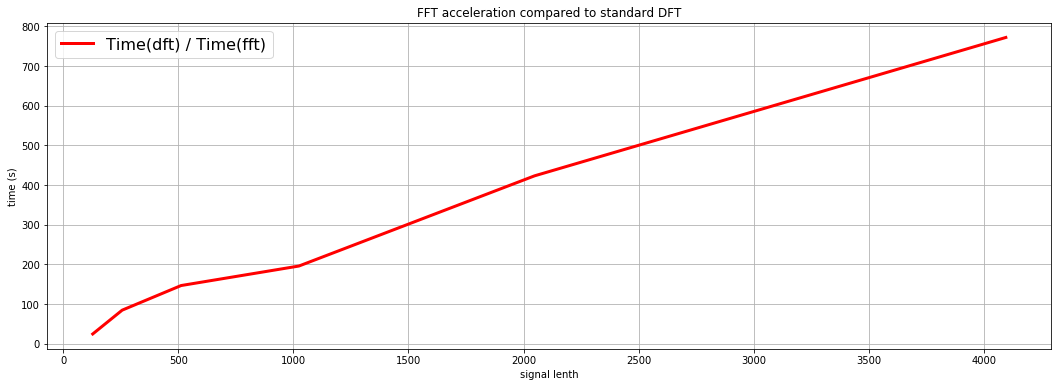

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

ax.plot(N_list, acceleration, color=(1, 0, 0), linewidth=3, ls="-", label="Time(dft) / Time(fft)")
ax.set(title="FFT acceleration compared to standard DFT", xlabel="signal lenth", ylabel="time (s)")
ax.legend(fontsize=16, loc=0)
ax.grid()
#ax.set(xlim=[0, N], ylim=[signal_x.min(), signal_x.max()])

plt.show()